### [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [22]:
import math, random, torch
import numpy as np
# import random
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# verbose = True   # print calculation output and weights and bias matrices 
verbose = False  # print calculation output only

In [24]:
def plot_losses(losses):
  # import matplotlib.pyplot as plt
  
  # Create a list of iterations
  iterations = range(len(losses))

  # Plot the loss as a function of iteration
  plt.plot(iterations, losses)

  # Add a title to the plot
  plt.title('Loss vs. Iteration')

  # Add labels to the x-axis and y-axis
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

In [25]:
def print_parameters(parameters):
  # number of parameters (e.g sum (weights + bias to each neuron and output))
  # MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
  # print(f'Number of parameters in MLP(2, [3, 3, 1]): {len(parameters())}\n')
  print(f'Total parameters: {len(parameters())}\n')  

  # print first 5 parameters
  for i, v in enumerate(parameters()):
    if i < 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')
  
  print('---')

  # print last 5 parameters   
  for i, v in enumerate(parameters()):
    if i >= len(parameters()) - 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')

In [26]:
def get_wt_n_b_mats(layers, verbose=False):
  ''' Get neuron's weights and bias for each layer.
  Inputs: If n = MLP(2, [3, 3, 1]), input is n.layers.

  return: two lists of np.arrays. The first list is weight matrix for each layer
          The second list is the bias matrix for each layer 
  '''
  layer_cnt = len(layers)  # number of layers
  w_mats = []  # list of weights matrix for each layer 
  b_mats = []  # list of bias matrix for each layer
  if verbose:
    print(f'layer_cnt: {layer_cnt}\n')
  for i, layer in enumerate(layers):
      neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer
      if verbose: 
        print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

        print('----')
      b_mat = []  # accumulate neuon's bias for each row     
      for j, neuron in enumerate(layer.neurons):
          if verbose:
            print(f'layer: {i}, neuron {j}')
          b = neuron.b.data  # bias of neuron 
          w_row = []  # accumulate neuon's weights for each row
          b_row = []  # accumulate neuon's bias for each row
          for k, w in enumerate(neuron.w):
              w_row.append(w.data)
              if verbose:
                print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
          if j == 0:            
              w_mat = np.array([w_row])
          else:
              w_mat = np.vstack((w_mat, w_row))
          
          b_mat.append(b)
          if verbose:
            print(f'b:  {b:10.7f}\n')
            print(f'b:  {b:10.7f}')        
            print(f'b_mat:  {b_mat}\n')
      w_mats.append(w_mat)  
      b_mats.append(np.array([b_mat]))        
      if verbose:
          print('------')

  zipped_w_n_b = zip(w_mats, b_mats)
  if verbose:
    for i, w_n_b in enumerate(zipped_w_n_b):
      print(f'layer: {i}')  # 1st layer is 0    
      print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
      print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  

  return w_mats, b_mats

In [27]:
def forward_pass(layers, verbose=verbose):
  # Get Neural Network's Weights and Biases Matrices
  # w_mats, b_mats = get_wt_n_b_mats(n.layers, verbose=verbose)
  w_mats, b_mats = get_wt_n_b_mats(layers, verbose=verbose)

  # Calculate Neural Network Output and Loss with Matrix Multiplication
  for layer in range(len(layers)):
    if layer == 0:  # first layer, use given inputs xs as inputs
      input = xs_mats_T[layer]
    else:  # after first layer, use outputs from preceding layers as inputs
      input = output

    weights = w_mats[layer]
    bias = np.transpose(b_mats[layer])

    weights_x_input = np.matmul(weights, input)
    weights_x_input_plus_bias = weights_x_input + bias

    # output = np.tanh(np.matmul(weights, input) + bias)
    output = np.tanh(weights_x_input_plus_bias)

    print(f'{"-"*50}')
    print(f'Calculate Output of Layer: {layer}')    
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_+_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')    

    # print(f'output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    
    print(f'Layer {layer} Output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    

  yout = output[0]
  err = (yout - ys)
  err_sq = (err**2)
  loss_sum = err_sq.sum()
  loss_mean = err_sq.mean()

  # print(f'-- Manual calculation results of neural network output and prediction error --')
  print(f'-- Results of neural network outputs and Loss --')  
  print(f'yout:           {yout}')   
  print(f'desired output: {ys}')   
  print(f'err:            {err}')
  print(f'err_sq:         {err_sq}')
  print(f'loss_sum:       {loss_sum}')
  print(f'loss_mean:      {loss_mean}')

  return yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats


### Micrograd Classes and Functions<br>* limited to neural network with one output, e.g. MLP(2, [3, 1])<br>* neural network with multiple outputs, e.g.  MLP(2, [3, 3]), will produce errors in backward pass 

In [28]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [29]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [30]:
class Neuron:
    
    def __init__(self, nin):
        # random numbers evenly distributed between -1 and 1    
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

#   &nbsp;
# - Human Brain and Artificial Neural Network - 

### Neurons in Human Brain
![](..\karpathy\img\neuron_of_human_brain.png)

### Simple Artificial Neural Network<br>* input layer: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2 nodes<br>* hidden layer 1: &nbsp;3 nodes<br>* hidden layer 2:&nbsp;&nbsp;3 nodes<br>*  output layer: &nbsp;&nbsp;&nbsp; 1 node<br>* node's bias and activation function are not shown

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\MLP (2, [3, 3, 1]).png">

### Artificial Neuron Function

<img src="..\karpathy\img\Artificial Neuron Function.png">

# &nbsp;
# - Visualize Math Operations in a Hidden Layer -

### * Assume hidden layer with two inputs (X0, X1), and three neurons (b0, b1, b2)<br>* Two sets of inputs (X0, X1) are shown in different shades of gray<br>* Two sets of outputs (Y0, Y1, Y2) are shown in corresponding shades of gray<br>* Multiple sets of inputs are processed in one matrix operation 

<img src="..\karpathy\img\Hidden Layer Matrix Operations.png">

# &nbsp;
# - Create Simple Neural Network with Micrograd -
##### MLP(2, [3, 3, 1])<br>* 2 input nodes<br>* 3 neurons in hidden layer 1<br>* 3 neurons in hidden layer 2<br>* 1 output node
##### Initialize Neurons Parameters <br>* parameters in layer 1: 3 neurons * (2 inputs + 1 bias) = &nbsp;&nbsp;&nbsp;&nbsp;  9<br>* parameters in layer 2: 3 neurons * (3 neurons + 1 bias) = 12<br>* parameters in layer 3: 1 output * (3 neurons + 1 bias) = &nbsp;&nbsp;&nbsp; 4<br>*  total parameters: 25

In [31]:
# create neural network and initialize weights and biases
n = MLP(2, [3, 3, 1])

# if verbose:
if True:
  print("Neuron parameters, initialized with random numbers")
  print_parameters(n.parameters)

Neuron parameters, initialized with random numbers
Total parameters: 25

i:  0,   0.9577464772
i:  1,   0.9751418417
i:  2,   0.8372221264
i:  3,  -0.6353202580
i:  4,   0.3016491539
---
i: 20,   0.1749448599
i: 21,   0.2171302088
i: 22,   0.6522623613
i: 23,   0.1670187681
i: 24,   0.9726202388


# &nbsp;
# - Set Inputs, Desired Outputs, Learning Rate -
##### Inputs<br>* 1st set: [2.0, 1.0]<br>* 2nd set: [3.0, -2.0]
##### Desired Outputs<br>* [1.0, -1.0] for all input sets
##### Learning Rate<br>* 0.05

In [32]:
# inputs
xs = [
  [2.0, 1.0],
  [3.0, -2.0]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [33]:
# if True:
if verbose:
	# print weights and bias of each layer
	for i, layer in enumerate(n.layers):
		neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer 
		print(f'layer: {i}, neuron_cnt: {neuron_cnt}, layer: {layer}')

# &nbsp;
# - Calculate Neural Network Outputs and Loss (i.e. Prediction Errors) -
##### * transpose inputs<br>* select activation function<br>* calculate output, (a.k.a) Forward Pass<br>* calculate Loss

##### Transpose Inputs

In [34]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 2)
xs_mats:
[array([[ 2.,  1.],
       [ 3., -2.]])]

xs_mats_T[0].shape: (2, 2)
xs_mats_T:
[array([[ 2.,  3.],
       [ 1., -2.]])]


##### Common Activation Functions

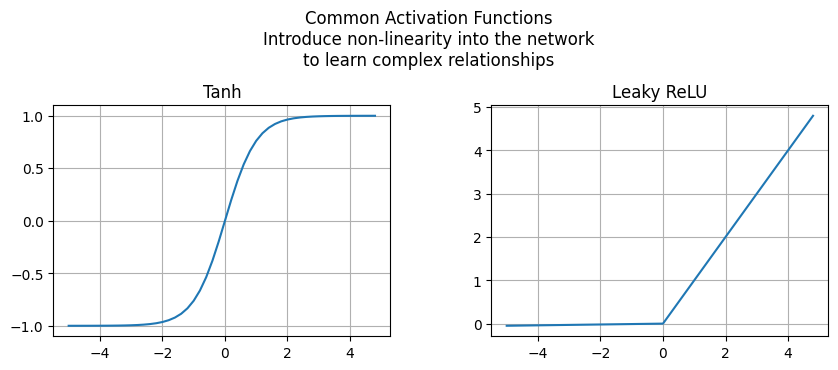

In [35]:
# Common Activation Functions
x = np.arange(-5, 5, 0.2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(x, np.tanh(x))
ax1.set_title("Tanh")
ax1.grid()

a = x[x < 0]*0.01
b = x[x >= 0]
y = np.concatenate((a, b))
ax2.grid()
ax2.plot(x, y)
ax2.set_title("Leaky ReLU")

plt_title = "Common Activation Functions\nIntroduce non-linearity into the network\nto learn complex relationships"
plt.suptitle(plt_title , fontsize=12, y=1.2)
plt.subplots_adjust(wspace=0.3)
plt.show()

##### Calculate Outputs and Loss Using Tanh Activation

In [36]:
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[ 0.95774648  0.97514184]
 [-0.63532026  0.30164915]
 [ 0.92521469  0.40127025]]

input (2, 2):
[[ 2.  3.]
 [ 1. -2.]]

weights_x_inputs (3, 2):
[[ 2.8906348   0.92295575]
 [-0.96899136 -2.50925908]
 [ 2.25169963  1.97310355]]

bias (3, 1):
[[ 0.83722213]
 [-0.80619265]
 [-0.90070751]]

weights_x_inputs_+_bias (3, 2):
[[ 3.72785692  1.76017787]
 [-1.77518402 -3.31545173]
 [ 1.35099212  1.07239604]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[ 0.99884441  0.94252287]
 [-0.94417483 -0.99736553]
 [ 0.87428726  0.79036223]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[-0.42898145 -0.9079466   0.27135091]
 [-0.0670093   0.40295687  0.76371632]
 [-0.60479214  0.01251942 -0.73803676]]

input (3, 2):
[[ 0.99884441  0.94252287]
 [-0.94417483 -0.99736553]
 [ 0.87428726  0.79036223]]

weights_x_inputs (3, 2):
[[ 0.66601324  0.71569532

In [37]:
print(f'-- Neural network outputs and Loss --')
print(f'yout:           {yout} <-- neural network output')   
print(f'desired output: {ys}')   
print(f'err:            {err}')
print(f'err_sq:         {err_sq}')
print(f'loss_sum:       {loss_sum} <-- sum(prediction_error)^2')
print(f'loss_mean:      {loss_mean} <-- mean(prediction_error)^2')


-- Neural network outputs and Loss --
yout:           [0.89456094 0.89251886] <-- neural network output
desired output: [1.0, -1.0]
err:            [-0.10543906  1.89251886]
err_sq:         [0.0111174  3.58162765]
loss_sum:       3.592745049438532 <-- sum(prediction_error)^2
loss_mean:      1.796372524719266 <-- mean(prediction_error)^2


##### Save original parameters

In [38]:
# save original parameters
param_org = [p.data for p in n.parameters()]

#   &nbsp;
# - How Artificial Neural Network Learns -

##### * calculate gradients (i.e. changes in Loss w.r.t. changes in each parameter)<br>* use gradients to adjust parameters in direction of less Loss<br>* repeat the steps

##### Example of calculating gradient for parameter W0<br>* calculate outputs and Loss<br>* increase W0 by small amount, e.g. 0.00001<br>* recalculate outputs and Loss<br>* calculate gradient (W0_grad = changes_in_Loss / changes_in_W0)
##### Increase W0 by small amount

In [39]:
# Increase W1 by h
h = .00001
loss_mean_before = loss_mean
print(f'loss_mean before increase Wo:  {loss_mean_before:10.7f}')
W0_before = n.parameters()[0].data  # W1
print(f'W0_before:                     {W0_before:10.7f}')
n.parameters()[0].data += h
W0_after = n.parameters()[0].data
print(f'W0_after:                      {W0_after:10.7f}') 
W0_dif = W0_after - W0_before
print(f'W0_dif:                        {W0_dif:10.7f} <-- increased W0 by a small amount') 

loss_mean before increase Wo:   1.7963725
W0_before:                      0.9577465
W0_after:                       0.9577565
W0_dif:                         0.0000100 <-- increased W0 by a small amount


##### Recalculate output and Loss with small changes in W0

In [40]:
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[ 0.95775648  0.97514184]
 [-0.63532026  0.30164915]
 [ 0.92521469  0.40127025]]

input (2, 2):
[[ 2.  3.]
 [ 1. -2.]]

weights_x_inputs (3, 2):
[[ 2.8906548   0.92298575]
 [-0.96899136 -2.50925908]
 [ 2.25169963  1.97310355]]

bias (3, 1):
[[ 0.83722213]
 [-0.80619265]
 [-0.90070751]]

weights_x_inputs_+_bias (3, 2):
[[ 3.72787692  1.76020787]
 [-1.77518402 -3.31545173]
 [ 1.35099212  1.07239604]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[ 0.99884446  0.94252622]
 [-0.94417483 -0.99736553]
 [ 0.87428726  0.79036223]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[-0.42898145 -0.9079466   0.27135091]
 [-0.0670093   0.40295687  0.76371632]
 [-0.60479214  0.01251942 -0.73803676]]

input (3, 2):
[[ 0.99884446  0.94252622]
 [-0.94417483 -0.99736553]
 [ 0.87428726  0.79036223]]

weights_x_inputs (3, 2):
[[ 0.66601322  0.71569388

##### Calculate gradient

In [41]:
loss_mean_after = loss_mean
loss_mean_dif = loss_mean_after - loss_mean_before
W0_grad = loss_mean_dif / W0_dif

print(f'-- Calculate outputs and changes in Loss --')
print(f'yout:              {yout}')   
print(f'desired output:    {ys}')   
print(f'err:               {err}')
print(f'err_sq:            {err_sq}')
print(f'loss_mean_before:  {loss_mean_before}')
print(f'loss_mean_after:   {loss_mean_after}\n')
print(f'-- Calcuclate gradient --')
print(f'loss_mean_dif:     {loss_mean_dif} <-- change in loss_mean')
print(f'W0_dif:            {W0_dif} <-- change in W0')
print(f'W0_grad:           {W0_grad} <-- (changes in loss_mean) / (changes in W0), manual calculation')

-- Calculate outputs and changes in Loss --
yout:              [0.89456094 0.89251878]
desired output:    [1.0, -1.0]
err:               [-0.10543906  1.89251878]
err_sq:            [0.0111174  3.58162732]
loss_mean_before:  1.796372524719266
loss_mean_after:   1.7963723579370334

-- Calcuclate gradient --
loss_mean_dif:     -1.6678223246913149e-07 <-- change in loss_mean
W0_dif:            9.99999999995449e-06 <-- change in W0
W0_grad:           -0.016678223246989053 <-- (changes in loss_mean) / (changes in W0), manual calculation


##### Calculate output and Loss with Micrograd<br>* change W0 back to initial value<br>* compare manual calculation vs Micrograd 

In [42]:
# change W1 back before Micrograd calculation
n.parameters()[0].data = W0_before

ypred = [n(x) for x in xs]
ypred_data = [v.data for v in ypred]  # extract data 
loss_mean = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) / len(ys) # low loss is better, perfect is loss = 0

print(f'-- Calculate neural network Loss and gradient using Micrograd --')
print(f'W0:          {n.parameters()[0].data}')
print(f'ypred_data:  {ypred_data}')
print(f'ys:          {ys}')
print(f'err_sq:      {err_sq}')
print(f'loss_mean:   {loss_mean} <-- loss_mean, Micrograd calculation same as manual calc. {loss_mean_before}')

-- Calculate neural network Loss and gradient using Micrograd --
W0:          0.9577464771620161
ypred_data:  [0.894560939174443, 0.8925188648705081]
ys:          [1.0, -1.0]
err_sq:      [0.0111174  3.58162732]
loss_mean:   Value(data = 1.796372524719266) <-- loss_mean, Micrograd calculation same as manual calc. 1.796372524719266


##### Calculate gradients and adjust parameters using Micrograd

In [43]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss_mean.backward()

# update weights and bias
print('-- adjust parameters,  parameter_adjusted = parameter_before - gradient * learning_rate --')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad

  if i == 0:  
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f} <-- gradient same as manual calc. W0_grad {W0_grad:13.10f}')
  else:
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')    

-- adjust parameters,  parameter_adjusted = parameter_before - gradient * learning_rate --
  0      0.9577464772    -0.0166786904           0.05000         0.9585804117 <-- gradient same as manual calc. W0_grad -0.0166782232
  1      0.9751418417     0.0111332769           0.05000         0.9745851778
  2      0.8372221264    -0.0055575420           0.05000         0.8375000035
  3     -0.6353202580     0.0000842081           0.05000        -0.6353244684
  4      0.3016491539     0.0001190077           0.05000         0.3016432035
  5     -0.8061926530     0.0000530903           0.05000        -0.8061953075
  6      0.9252146861     0.0971035463           0.05000         0.9203595088
  7      0.4012702534    -0.0671790754           0.05000         0.4046292072
  8     -0.9007075084     0.0320187948           0.05000        -0.9023084482
  9     -0.4289814534     0.0519137097           0.05000        -0.4315771389
 10     -0.9079465958    -0.0553159568           0.05000        -0.905180

##### Repeat the steps using Micrograd:<br>* calculate Loss<br>* calculate gradient<br>* adjust parameters in direction of less Loss

In [44]:
# Create a list of losses
losses_mean = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  # loss is mean-square-errors
  loss_mean = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) / len(ys) # low loss is better, perfect is loss = 0  
  losses_mean.append(loss_mean.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss_mean.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss_mean: {loss_mean.data}')   
  # print('-------')

ypred: [Value(data = 0.883673064166882), Value(data = 0.8810915290683607)]
step: 0, loss_mean: 1.776018648366533
ypred: [Value(data = 0.8707489169734627), Value(data = 0.8674691104280573)]
step: 1, loss_mean: 1.752073360433246
ypred: [Value(data = 0.8552641311838616), Value(data = 0.8510688333502018)]
step: 2, loss_mean: 1.72370214876122
ypred: [Value(data = 0.8365379601366699), Value(data = 0.8311262423959258)]
step: 3, loss_mean: 1.6898715770336519
ypred: [Value(data = 0.813693242565577), Value(data = 0.8066434847434785)]
step: 4, loss_mean: 1.6493354444158943
ypred: [Value(data = 0.7856224988649652), Value(data = 0.7763392182441095)]
step: 5, loss_mean: 1.6006693656324982
ypred: [Value(data = 0.7509874522984977), Value(data = 0.738627942363307)]
step: 6, loss_mean: 1.54241718543963
ypred: [Value(data = 0.7083115070753188), Value(data = 0.6916933378678318)]
step: 7, loss_mean: 1.473454263145539
ypred: [Value(data = 0.6562707576189759), Value(data = 0.633777061230029)]
step: 8, loss_m

##### Plot Loss

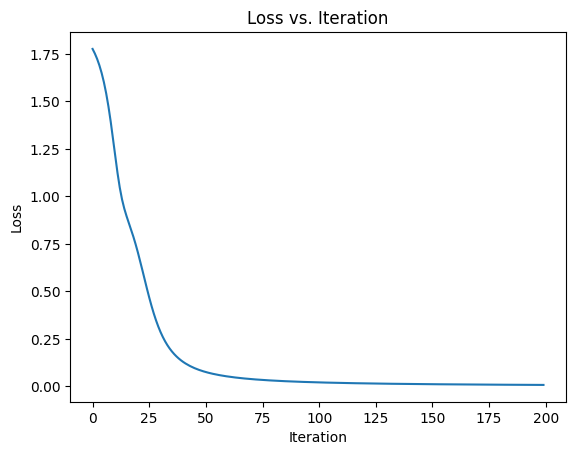

In [45]:
plot_losses(losses_mean)

##### Calculate outputs and Loss after last parameter adjustment

In [46]:
# calculate outputs and Loss after last parameter adjustment
ypred = [n(x) for x in xs]
loss_mean = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) / len(ys) # low loss is better, perfect is loss = 0
ypred_data = [value.data for value in ypred]

print(f'\n- Calculate outputs and Loss at end of iteration -')
print(f'ypred_data: {ypred_data}')
print(f'loss_mean: {loss_mean.data}\n\n')

# check calculation using forward pass function
print(f'Calculate outputs and Loss using optimized parameters')
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)


- Calculate outputs and Loss at end of iteration -
ypred_data: [0.9149490723018473, -0.9070979027169479]
loss_mean: 0.007932229990953037


Calculate outputs and Loss using optimized parameters
--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[ 1.06741367  0.90091618]
 [-0.54845229  0.35337235]
 [ 0.58591718  1.1081502 ]]

input (2, 2):
[[ 2.  3.]
 [ 1. -2.]]

weights_x_inputs (3, 2):
[[ 3.03574352  1.40040865]
 [-0.74353222 -2.35210157]
 [ 2.27998456 -0.45854887]]

bias (3, 1):
[[ 0.87361869]
 [-0.76157449]
 [-0.94513788]]

weights_x_inputs_+_bias (3, 2):
[[ 3.90936221  2.27402733]
 [-1.50510672 -3.11367607]
 [ 1.33484669 -1.40368674]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[ 0.99919605  0.97904629]
 [-0.90606682 -0.99605844]
 [ 0.87042891 -0.88614595]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[-0.49723751 -0.82750036  0.40181865]
 [-0.17253705  0.58336859  1.4355

##### Changes in parameters after optimization

In [47]:
# save parameters
param_optmz = [p.data for p in n.parameters()]
param_comp = zip(param_org, param_optmz)

# print(f'i        param_new      param_org      param_dif')
print(f'i   param_optimized      param_org      param_dif')
for i, param_org_new in enumerate(param_comp):
  p_org = param_org_new[0]
  p_new = param_org_new[1]  
  p_dif = p_new - p_org
  print(f'{i:<4} {p_new:>14.10f} {p_org:>14.10f} {p_dif:>14.10f}')  


i   param_optimized      param_org      param_dif
0      1.0674136705   0.9577464772   0.1096671934
1      0.9009161816   0.9751418417  -0.0742256601
2      0.8736186864   0.8372221264   0.0363965600
3     -0.5484522882  -0.6353202580   0.0868679698
4      0.3533723547   0.3016491539   0.0517232007
5     -0.7615744944  -0.8061926530   0.0446181586
6      0.5859171801   0.9252146861  -0.3392975060
7      1.1081502043   0.4012702534   0.7068799509
8     -0.9451378751  -0.9007075084  -0.0444303667
9     -0.4972375139  -0.4289814534  -0.0682560605
10    -0.8275003604  -0.9079465958   0.0804462354
11     0.4018186486   0.2713509118   0.1304677368
12    -0.1765851822  -0.1029813056  -0.0736038765
13    -0.1725370504  -0.0670093025  -0.1055277479
14     0.5833685892   0.4029568716   0.1804117176
15     1.4355299694   0.7637163234   0.6718136460
16     0.6350676662   0.7688356157  -0.1337679495
17    -0.9157095199  -0.6047921359  -0.3109173840
18     0.3420243048   0.0125194248   0.3295048799


#   &nbsp;
# - Build Same Model with PyTorch -

In [48]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(2, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)  
        return x

model = MLP_torch()

# # inputs
# xs = [
#   [2.0, 3.0, -1.0],
#   [3.0, -1.0, 0.5]
# ]

# # desired targets
# ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# # learning rate (i.e. step size)
# learning_rate = 0.05

losses = []
for epoch in range(200):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")

Epoch 0 loss: 0.8817610740661621
Epoch 10 loss: 0.2369905412197113
Epoch 20 loss: 0.034623563289642334
Epoch 30 loss: 0.004062350373715162
Epoch 40 loss: 0.0004483500379137695
Epoch 50 loss: 4.855735824094154e-05
Epoch 60 loss: 5.2271989261498675e-06
Epoch 70 loss: 5.616255407403514e-07
Epoch 80 loss: 6.023849152825278e-08
Epoch 90 loss: 6.469919711094008e-09
Epoch 100 loss: 7.036788929326576e-10
Epoch 110 loss: 7.58468843287119e-11
Epoch 120 loss: 8.776979143476638e-12
Epoch 130 loss: 9.237055564881302e-13
Epoch 140 loss: 3.9257486150745535e-13
Epoch 150 loss: 2.007283228522283e-13
Epoch 160 loss: 2.007283228522283e-13
Epoch 170 loss: 1.3145040611561853e-13
Epoch 180 loss: 1.2789769243681803e-13
Epoch 190 loss: 9.237055564881302e-14

Prediction:
tensor([[ 1.0000],
        [-1.0000]])
Loss: 5.684341886080802e-14


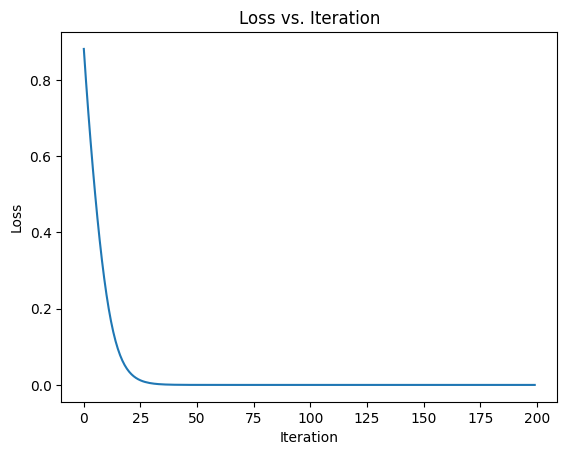

In [49]:
plot_losses(losses)

In [50]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')

# l_items is a list of [weight matrix, bias matrix, ..., weight matrix, bias matrix] 
l_items = list(model.parameters())
if len(l_items) % 2 == 0:  # True divisible by 2
  for i in range(0, len(l_items), 2):  # i: 0, 2, ..., len(l_items)-2
    if i == 0:  # use transposed t_xs as input only at the first time
      x0 = torch.clone(t_xs).detach()  # clone t_xs without autograd history
      input = torch.transpose(x0, 0, 1)  # columns of x0 becomes rows of input
    else:  # use previous output as input 
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 1.0], [3.0, -2.0]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([3, 2]):
tensor([[-0.0339, -0.7617],
        [-0.5586, -0.4535],
        [ 0.1567, -0.7489]])

input,  torch.Size([2, 2]):
tensor([[ 2.,  3.],
        [ 1., -2.]])

w * input,  torch.Size([3, 2]):
tensor([[-0.8295,  1.4216],
        [-1.5707, -0.7689],
        [-0.4355,  1.9680]])

bT,  torch.Size([3, 1]):
tensor([[-0.1504],
        [ 0.0893],
        [ 0.1792]])

w * input + bT,  torch.Size([3, 2]):
tensor([[-0.9799,  1.2712],
        [-1.4814, -0.6796],
        [-0.2563,  2.1472]])

output,  torch.Size([3, 2]):
tensor([[-0.7530,  0.8541],
        [-0.9017, -0.5913],
        [-0.2509,  0.9731]])


layer: 1.0,  i: 2

w,  torch.Size([3, 3]):
tensor([[ 0.9578,  0.0492,  0.6029],
        [-0.1170, -0.0358, -0.2074],
        [ 0.0722, -0.2319,  0.0228]])

input,  torch.Size([3, 2]):
tensor([[-0.7530,  0.8541],
        [-0.9017, -0.5913],
        [-0.2509,  0.9731]])

w * input,  torch.S

In [51]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [52]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)

# loss = torch.sum(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 1.0000, -1.0000]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(5.6843e-14)

In [53]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 1.0000, -1.0000]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-2.3842e-07,  2.3842e-07]])
squared_difference: tensor([[5.6843e-14, 5.6843e-14]])


tensor(5.6843e-14)

In [54]:
# for item in output.item:
#   print(item)
# type(output)
output.tolist()[0]


[0.9999997615814209, -0.9999997615814209]

In [55]:
import numpy as np

def mse_loss(y_true, y_pred):
  """Calculates the mean squared error loss.

  Args:
    y_true: The ground truth labels.
    y_pred: The predicted labels.

  Returns:
    The mean squared error loss.
  """

  loss = np.mean((y_true - y_pred)**2)
  return loss

def main():
  """Main function."""

  # y_true = np.array([1, 2, 3, 4, 5])
  y_true = np.array([1.0, -1.0])

  # y_pred = np.array([0, 1, 2, 3, 4])
  # y_pred = np.array([0.9997345209121704, -0.9980572462081909])
  y_pred = np.array(output.tolist()[0])  

  loss = mse_loss(y_true, y_pred)
  print(loss)

if __name__ == "__main__":
  main()

5.684341886080802e-14


In [56]:
len(squared_difference)


1

In [57]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(5.6843e-14)

In [58]:
torch.sum((output - torch.tensor(ys))**2)


tensor(1.1369e-13)

##### Check Output and Gradient Calculation with PyTorch

In [59]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f} <-- result matched micrograd')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f} <-- result matched micrograd')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000 <-- result matched micrograd
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107 <-- result matched micrograd


### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, initialize weights and biases, define inputs and desired outputs 

In [60]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [61]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'parameters in MLP: {len(n.parameters())}\n')

# print first 5 parameters
for i, v in enumerate(n.parameters()):
  if i < 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')
 
print('---')

# print last 5 parameters   
for i, v in enumerate(n.parameters()):
  if i >= len(n.parameters()) - 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')

parameters in MLP: 41

i:  0,   0.5672603693
i:  1,  -0.9308749333
i:  2,  -0.1328618591
i:  3,  -0.9934804732
i:  4,  -0.9238571587
---
i: 36,  -0.3181930065
i: 37,   0.3049070635
i: 38,   0.2348938724
i: 39,   0.4388297685
i: 40,  -0.8605170218


### ---- Start: Calculate Neural Network Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [62]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 3)
xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [63]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'layer: {i}, neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}\n')
        # print(f'b:  {b:10.7f}')        
        # print(f'b_mat:  {b_mat}\n')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('------')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
layer: 0, neuron 0
w0:  0.5672604,   w0.grad:  0.0000000
w1: -0.9308749,   w1.grad:  0.0000000
w2: -0.1328619,   w2.grad:  0.0000000
b:  -0.9934805

layer: 0, neuron 1
w0: -0.9238572,   w0.grad:  0.0000000
w1: -0.1987562,   w1.grad:  0.0000000
w2: -0.3712072,   w2.grad:  0.0000000
b:  -0.2974288

layer: 0, neuron 2
w0:  0.9784890,   w0.grad:  0.0000000
w1:  0.0759947,   w1.grad:  0.0000000
w2: -0.4554297,   w2.grad:  0.0000000
b:  -0.7458851

layer: 0, neuron 3
w0:  0.6475398,   w0.grad:  0.0000000
w1:  0.2347478,   w1.grad:  0.0000000
w2:  0.2093017,   w2.grad:  0.0000000
b:   0.9722971

------
layer: 1, neuron_cnt: 4
----
layer: 1, neuron 0
w0: -0.7885578,   w0.grad:  0.0000000
w1:  0.8505186,   w1.grad:  0.0000000
w2: -0.2615981,   w2.grad:  0.0000000
w3:  0.8000956,   w3.grad:  0.0000000
b:  -0.9038807

layer: 1, neuron 1
w0:  0.8357337,   w0.grad:  0.0000000
w1:  0.7531701,   w1.grad:  0.0000000
w2:  0.0654096,   w2.grad:  0.0000000
w3:  

##### Print Neural Network's Weights and Biases Matrices

In [64]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
  print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  
    

i: 0
w_mat(4, 3):
[[ 0.56726037 -0.93087493 -0.13286186]
 [-0.92385716 -0.19875617 -0.37120724]
 [ 0.978489    0.07599466 -0.45542967]
 [ 0.6475398   0.23474776  0.20930173]]
b_mat(1, 4):
[[-0.99348047 -0.29742876 -0.74588512  0.97229715]]

i: 1
w_mat(4, 4):
[[-0.78855782  0.85051858 -0.2615981   0.80009565]
 [ 0.83573371  0.75317011  0.06540962  0.94857421]
 [-0.71611461 -0.14357868  0.33875883  0.52695475]
 [ 0.54708323 -0.32567418  0.55143655  0.6022213 ]]
b_mat(1, 4):
[[-0.90388066  0.00612193 -0.12647767  0.41289712]]

i: 2
w_mat(1, 4):
[[-0.31819301  0.30490706  0.23489387  0.43882977]]
b_mat(1, 1):
[[-0.86051702]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

<img src="..\karpathy\img\neural_mat.PNG">

In [65]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])

  weights_x_input = np.matmul(weights, input)
  weights_x_input_plus_bias = weights_x_input + bias

  # output = np.tanh(np.matmul(weights, input) + bias)
  output = np.tanh(weights_x_input_plus_bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_plus_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')

    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')


--------------------------------------------------
layer: 0
weights (4, 3):
[[ 0.56726037 -0.93087493 -0.13286186]
 [-0.92385716 -0.19875617 -0.37120724]
 [ 0.978489    0.07599466 -0.45542967]
 [ 0.6475398   0.23474776  0.20930173]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

weights_x_inputs (4, 2):
[[-1.5252422   2.56622511]
 [-2.07277559 -2.75841892]
 [ 2.64039164  2.63175751]
 [ 1.79002116  1.81252251]]

bias (4, 1):
[[-0.99348047]
 [-0.29742876]
 [-0.74588512]
 [ 0.97229715]]

weights_x_inputs_plus_bias (4, 2):
[[-2.51872268  1.57274464]
 [-2.37020435 -3.05584768]
 [ 1.89450651  1.88587238]
 [ 2.76231831  2.78481965]]

output (4, 2):
[[-0.98710309  0.91746124]
 [-0.98268113 -0.99557623]
 [ 0.95576468  0.95501151]
 [ 0.99205704  0.99240524]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[-0.78855782  0.85051858 -0.2615981   0.80009565]
 [ 0.83573371  0.75317011  0.06540962  0.94857421]
 [-0.71611461 -0.14357868  0.33875883  0.52695475]
 [

### ### ---- End: Calculate Neural Network Output and Loss with Matrix Multiplication ---- ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [66]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [-0.2851676290894969, 0.15762945644028326]
ys:                 [1.0, -1.0]
loss_data:          2.9917617932777447


#### Micrograd backward pass and update parameters

In [67]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0      0.5672603693    -0.0847238607           0.05000         0.5714965623
  1     -0.9308749333    -0.0682482601           0.05000        -0.9274625203
  2     -0.1328618591     0.0209664646           0.05000        -0.1339101823
  3     -0.9934804732    -0.0370130639           0.05000        -0.9916298200
  4     -0.9238571587     0.0179409908           0.05000        -0.9247542083
  5     -0.1987561732     0.0232542568           0.05000        -0.1999188860
  6     -0.3712072421    -0.0076405938           0.05000        -0.3708252124
  7     -0.2974287561     0.0086380200           0.05000        -0.2978606571
  8      0.9784889987    -0.0054065457           0.05000         0.9787593260
  9      0.0759946575    -0.1167579322           0.05000         0.0818325541
 10     -0.4554296654     0.0422116778           0.05000        -0.4575402493
 11     -0.7458851228    -0.0125803741

### Improve Prediction with Parameter Iteration 

In [68]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = -0.12327954174895615), Value(data = -0.030457939816085133)]
step: 0, loss: 2.2017687353774145
-------
ypred: [Value(data = 0.02556723882489603), Value(data = -0.18764637134730025)]
step: 1, loss: 1.6094376240365458
-------
ypred: [Value(data = 0.1654939431703702), Value(data = -0.3162495987558361)]
step: 2, loss: 1.1639149700868927
-------
ypred: [Value(data = 0.2904288474425077), Value(data = -0.41953989469746694)]
step: 3, loss: 0.840425154389596
-------
ypred: [Value(data = 0.3937338297722441), Value(data = -0.5001119819911499)]
step: 4, loss: 0.6174466997114467
-------
ypred: [Value(data = 0.474854655374383), Value(data = -0.5620715708881949)]
step: 5, loss: 0.46755894200629133
-------
ypred: [Value(data = 0.5375486389378261), Value(data = -0.6099280906263752)]
step: 6, loss: 0.36601735583064243
-------
ypred: [Value(data = 0.586333202596324), Value(data = -0.6474599536954297)]
step: 7, loss: 0.2954047035226424
-------
ypred: [Value(data = 0.6249264107243733), 

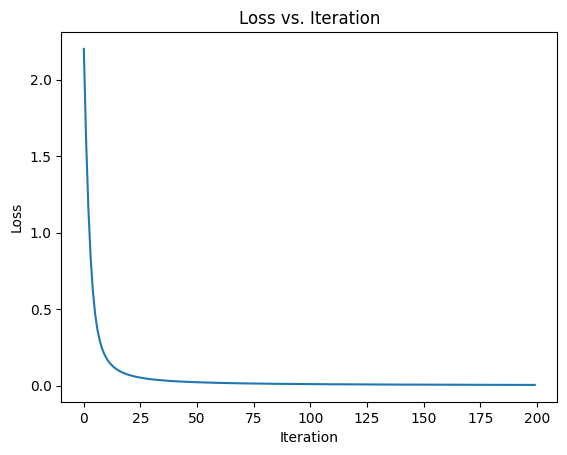

In [69]:
plot_losses(losses)

### Build same model with pyTorch 

In [70]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 1.7877897024154663
Epoch 10 loss: 1.0050044059753418
Epoch 20 loss: 0.7696520686149597
Epoch 30 loss: 0.08035781979560852

Prediction:
tensor([[ 0.9583],
        [-0.9734]])
Loss: 0.0018944533076137304


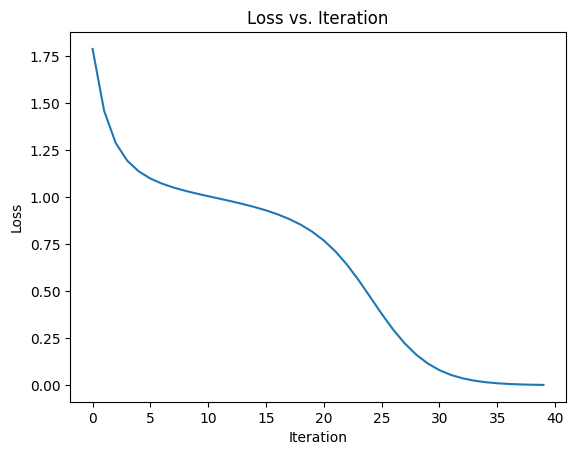

In [71]:
plot_losses(losses)

In [72]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[-0.4545, -0.1869,  0.2342],
        [-0.1027,  0.6046, -0.5816],
        [ 0.5612, -0.3682,  0.3110],
        [ 0.1195,  0.5399,  0.2733]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[-1.7039, -1.0595],
        [ 2.1899, -1.2034],
        [-0.2933,  2.2075],
        [ 1.5855, -0.0447]])

bT,  torch.Size([4, 1]):
tensor([[ 0.1367],
        [ 0.2563],
        [ 0.2472],
        [-0.4825]])

w * input + bT,  torch.Size([4, 2]):
tensor([[-1.5672, -0.9228],
        [ 2.4462, -0.9471],
        [-0.0461,  2.4546],
        [ 1.1030, -0.5272]])

output,  torch.Size([4, 2]):
tensor([[-0.9166, -0.7272],
        [ 0.9851, -0.7385],
        [-0.0461,  0.9854],
        [ 0.8016, -0.4832]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[ 0.2248,  0.017

In [73]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [74]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference)
loss

tensor([[ 0.9583, -0.9734]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(0.0024)

In [75]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference) / 2
loss

tensor([[ 0.9583, -0.9734]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-0.0417,  0.0266]])
squared_difference: tensor([[0.0017, 0.0007]])


tensor(0.0012)

In [76]:
difference
len(squared_difference)

1

In [77]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(0.0012)

In [78]:
torch.sum((output - torch.tensor(ys))**2)

tensor(0.0024)